# 1. Data Preperation

In [23]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [24]:
#Load pre-existing park data
parks_lst_gdf = gpd.read_file('Data/Riyadh_parks_with_LST.geojson')
print("Loaded parks_gdf with columns:", parks_lst_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'lst_buffer_30m',
       'lst_buffer_60m', 'lst_buffer_90m', 'lst_buffer_120m',
       'lst_buffer_150m', 'lst_buffer_180m', 'lst_buffer_210m',
       'lst_buffer_240m', 'lst_buffer_270m', 'lst_buffer_300m', 'lst_park',
       'park_pixel_count', 'lst_data', 'cubic_coeffs', 'r_squared', 'PCD',
       'PCI', 'PCA', 'PCE', 'geometry'],
      dtype='object')


In [25]:
# Select relevant columns for the analysis
data_df = parks_lst_gdf[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE']].copy() ## Create a copy of the specified columns to avoid SettingWithCopyWarning

In [26]:
# Check if any row has na

num_rows_with_na = data_df.isna().any(axis=1).sum()
print(f'Number of rows with NaN values: {num_rows_with_na}')


Number of rows with NaN values: 0


Here, the independent variables were normalized using StandardScaler which performs same transformation as the z score method used in litratire [Sun et al., 2024](https://www.sciencedirect.com/science/article/abs/pii/S1618866724000621)

In [5]:
# scaler = StandardScaler()

# data_df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']] = scaler.fit_transform(data_df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']])

In [35]:
# Create the subset where 'PCI' is less than 0
data_df_cooling = data_df[data_df['PCI'] < 0].copy()
data_df_heating = data_df[data_df['PCI'] > 0].copy()

print(f"Number of parks with cooling effect: {len(data_df_cooling)}")
print(f"Number of parks with heating effect: {len(data_df_heating)}")


Number of parks with cooling effect: 68
Number of parks with heating effect: 153


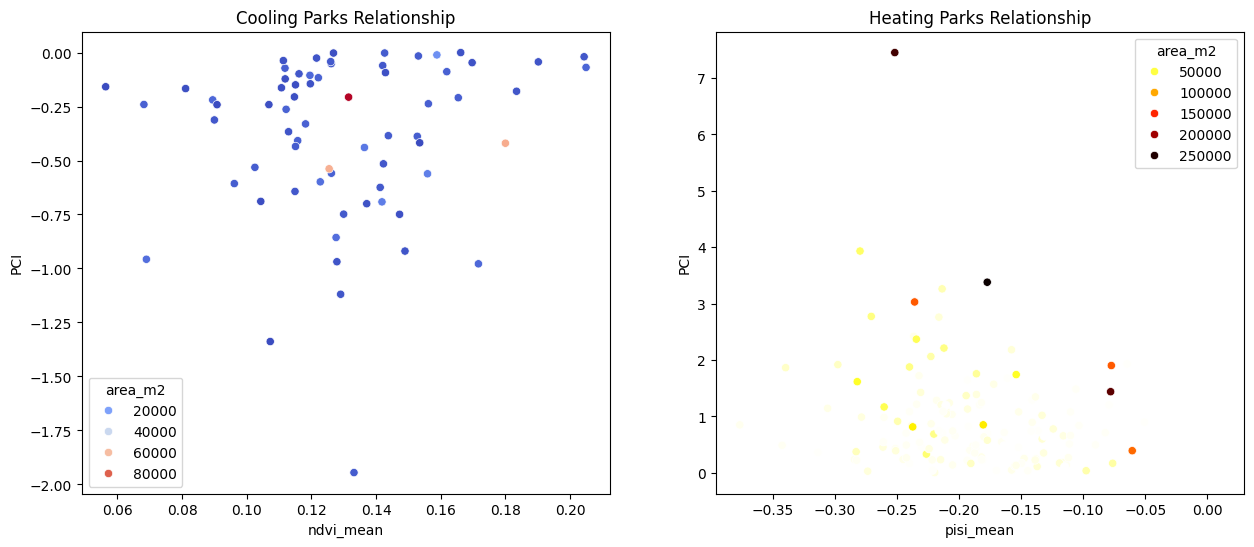

In [37]:
# Visualize fundamental differences
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=data_df_cooling, x='ndvi_mean', y='PCI', hue='area_m2', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=data_df_heating, x='pisi_mean', y='PCI', hue='area_m2', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

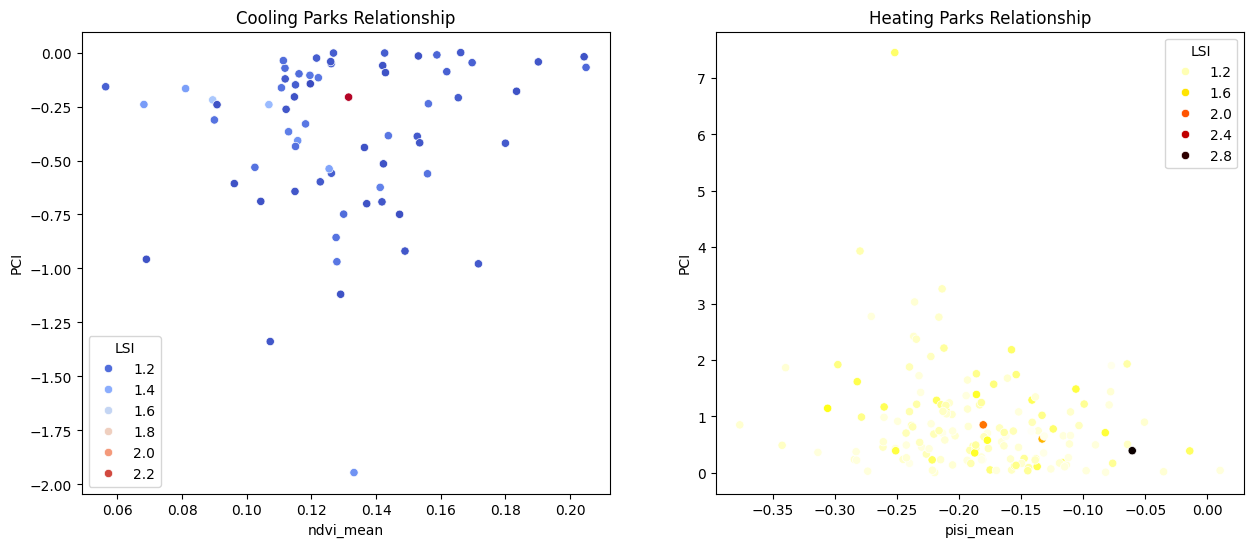

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=data_df_cooling, x='ndvi_mean', y='PCI', hue='LSI', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=data_df_heating, x='pisi_mean', y='PCI', hue='LSI', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

In [6]:
# data_df_cooling = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

# 2. Initial Exploration

This section performs Pearson correlation analysis to explore the influence of various factors on LST metrics preliminarily

In [8]:
correlations = data_df.corr()
p_values = pd.DataFrame(index=data_df.columns, columns=data_df.columns)
for col1 in data_df.columns:
    for col2 in data_df.columns:
        corr, p_val = stats.pearsonr(data_df[col1], data_df[col2])
        p_values.loc[col1, col2] = p_val

print("\nPearson Correlation Coefficients:")
print(correlations.round(3))
print("\nP-Values for Correlation Significance:")
print(p_values.round(3))


Pearson Correlation Coefficients:
           ndvi_mean  pisi_mean  area_m2    LSI    PCI    PCA    PCE
ndvi_mean      1.000     -0.802    0.102 -0.100  0.441  0.083 -0.268
pisi_mean     -0.802      1.000   -0.057  0.095 -0.295 -0.017  0.311
area_m2        0.102     -0.057    1.000  0.264  0.507  0.500 -0.334
LSI           -0.100      0.095    0.264  1.000  0.033  0.382 -0.174
PCI            0.441     -0.295    0.507  0.033  1.000  0.406 -0.170
PCA            0.083     -0.017    0.500  0.382  0.406  1.000  0.096
PCE           -0.268      0.311   -0.334 -0.174 -0.170  0.096  1.000

P-Values for Correlation Significance:
          ndvi_mean pisi_mean   area_m2       LSI       PCI       PCA  \
ndvi_mean       0.0       0.0  0.130668  0.140058       0.0  0.218029   
pisi_mean       0.0       0.0  0.397901  0.160858  0.000008  0.796555   
area_m2    0.130668  0.397901       0.0  0.000071       0.0       0.0   
LSI        0.140058  0.160858  0.000071       0.0  0.627981       0.0   
PCI     

- A strong negative correlation between ndvi_mean and pisi_mean (r = -0.802, p = 0.0), indicating an inverse relationship where higher vegetation cover reduces impervious surfaces.
- A moderate positive correlation between ndvi_mean and PCI (r = 0.441, p = 0.0), suggesting that increased vegetation enhances cooling intensity, with parks exhibiting higher NDVI values tending toward negative PCI values.
- A moderate negative correlation between pisi_mean and PCI (r = -0.295, p = 0.000008), implying that greater imperviousness diminishes cooling effects, aligning with urban heat island dynamics.
- A strong positive correlation between area_m2 and both PCI (r = 0.507, p = 0.0) and PCA (r = 0.500, p = 0.0), indicating that larger parks exhibit greater cooling intensity and spatial influence, though efficiency (PCE) decreases with size (r = -0.334, p = 0.0).
- A moderate positive correlation between LSI and PCA (r = 0.382, p = 0.0), suggesting that park shape complexity increases the area of cooling influence, though its impact on PCI and PCE is weak (p > 0.05).
- LSI (r = 0.033, p = 0.627981), indicating shape has minimal linear impact on intensity.

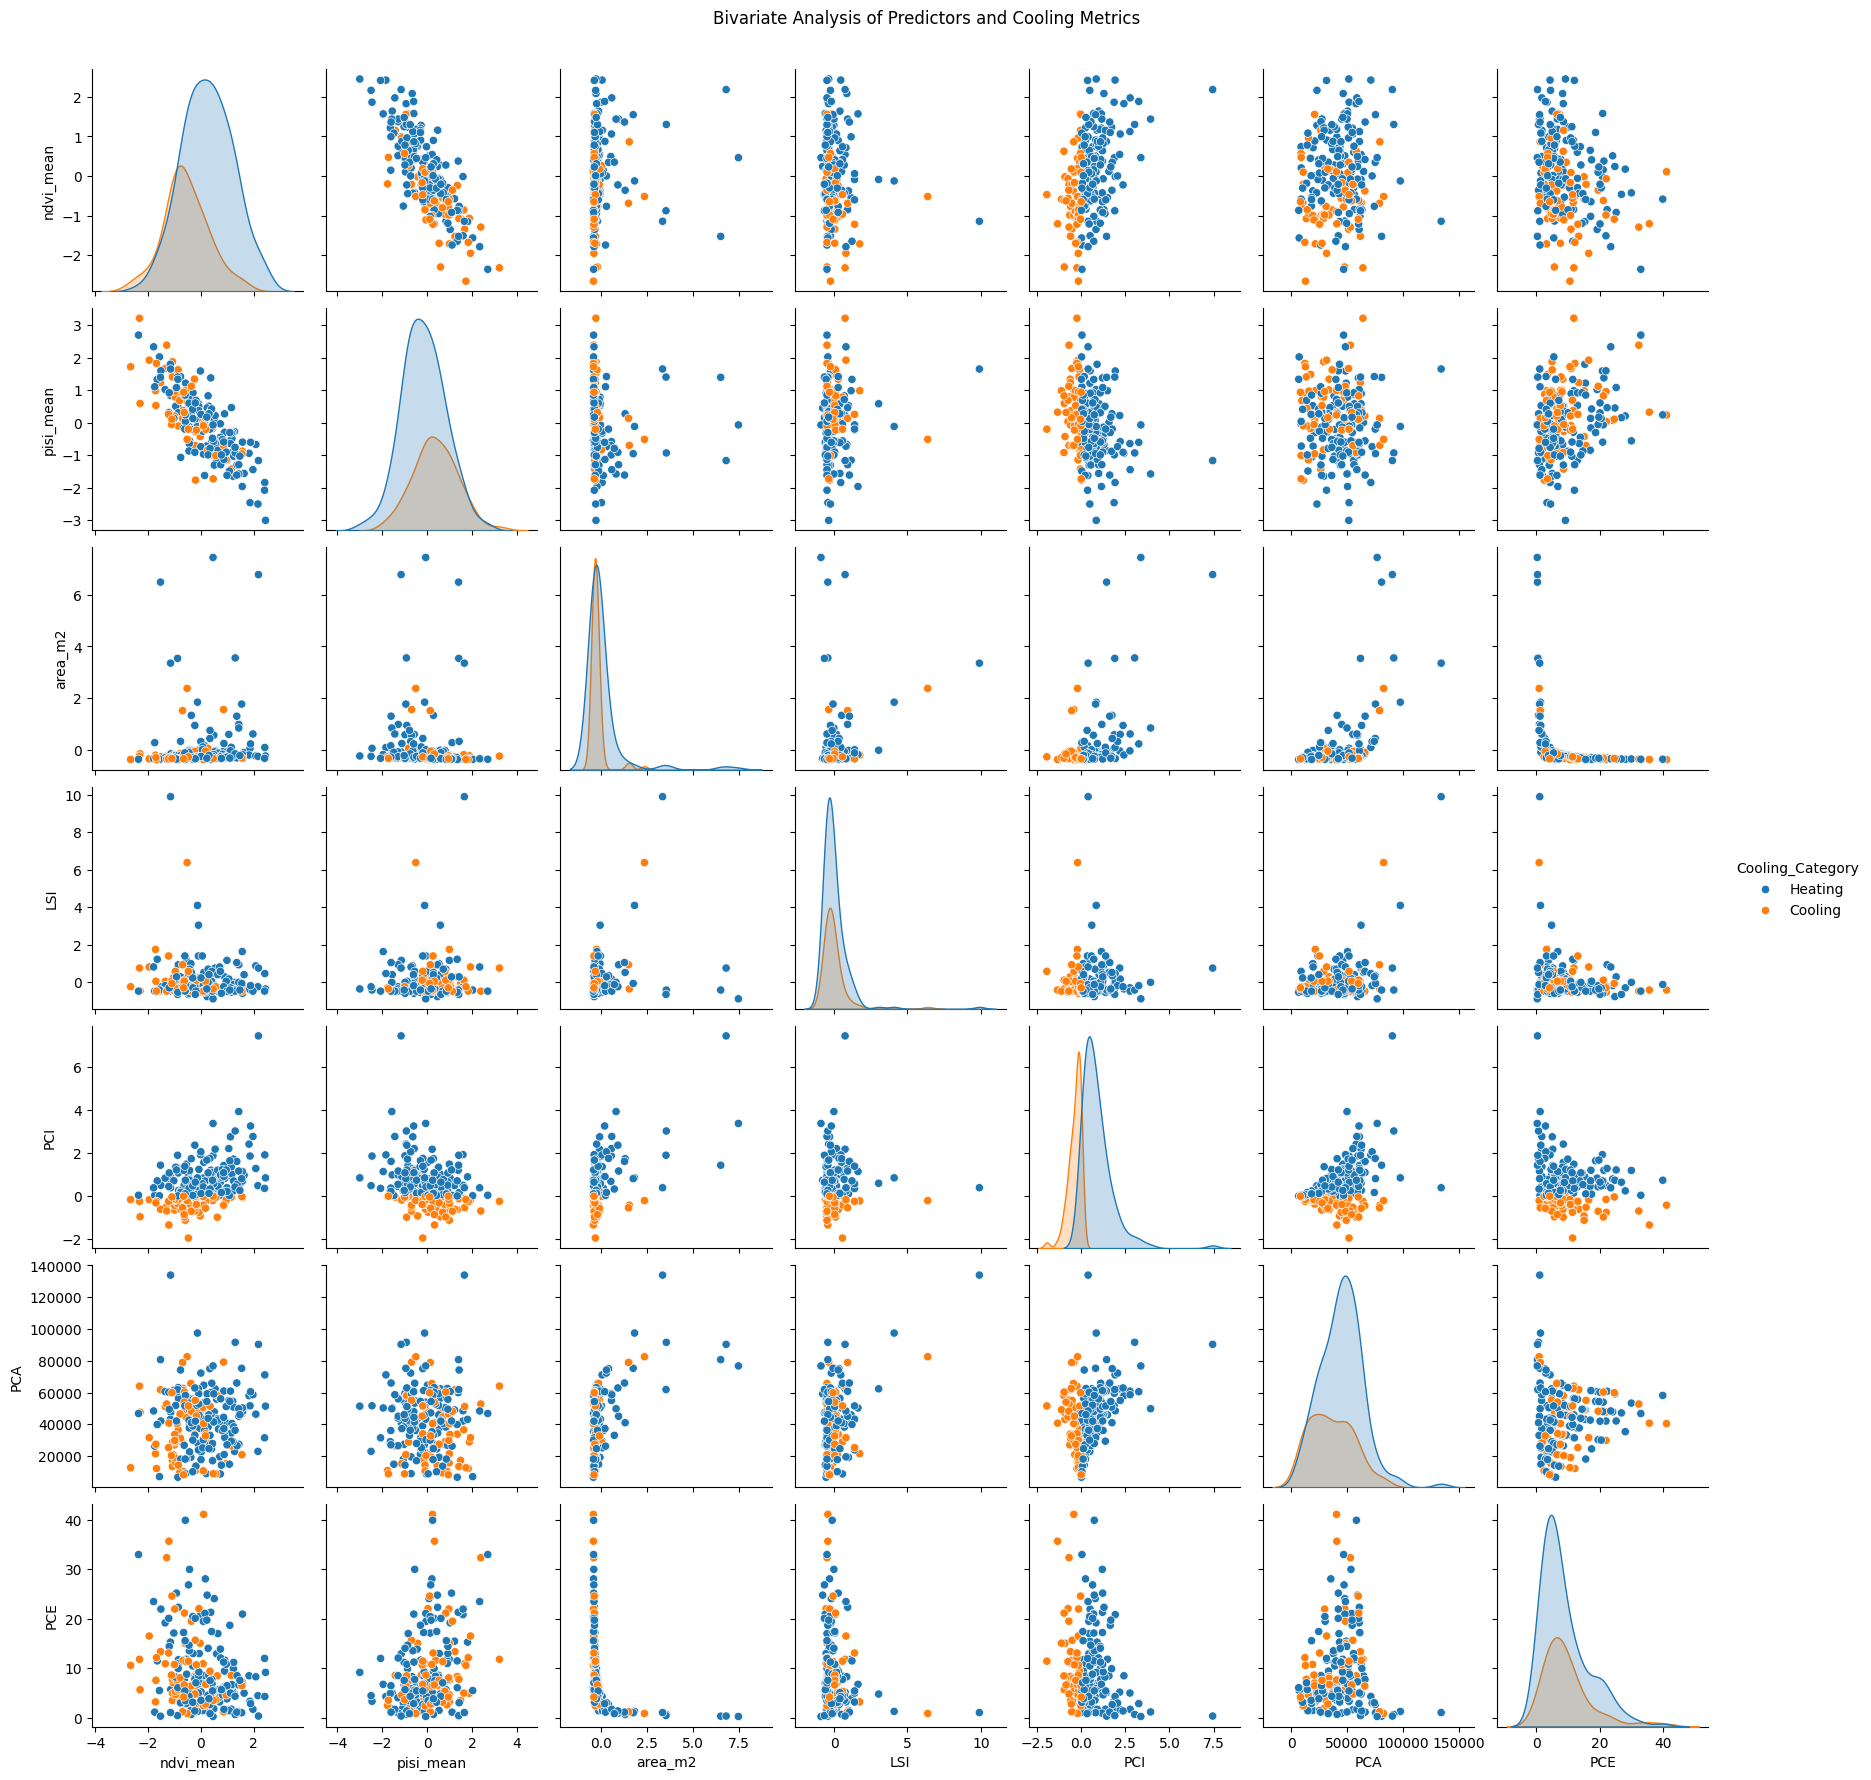

In [7]:
data_df['PCI'] = pd.to_numeric(data_df['PCI'], errors='coerce')  # Convert to numeric

# Add hue column for cooling/heating categorization
data_df['Cooling_Category'] = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

# Bivariate analysis with corrected hue
sns.pairplot(data_df, hue='Cooling_Category', vars=['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE'], diag_kind='kde')
plt.suptitle('Bivariate Analysis of Predictors and Cooling Metrics', y=1.02)
plt.show()

# 3. Regression Analysis

## 3.1. Model 1

From the correlation matrix, ndvi_mean and pisi_mean show strong negative correlation (r = -0.802), including both in the same model will cause multicollinearity problems (unstable coefficients, inflated standard errors)


===== Cooling Parks - PCI Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.3516
Date:                Wed, 23 Jul 2025   Prob (F-statistic):              0.842
Time:                        23:52:50   Log-Likelihood:                -27.676
No. Observations:                  68   AIC:                             65.35
Df Residuals:                      63   BIC:                             76.45
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

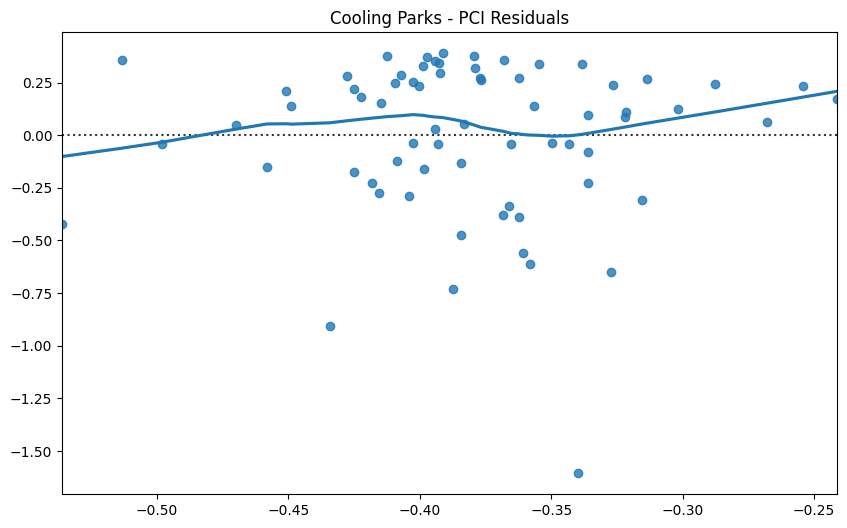


===== Cooling Parks - PCA Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCA   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     7.215
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           7.55e-05
Time:                        23:52:50   Log-Likelihood:                -753.93
No. Observations:                  68   AIC:                             1518.
Df Residuals:                      63   BIC:                             1529.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4

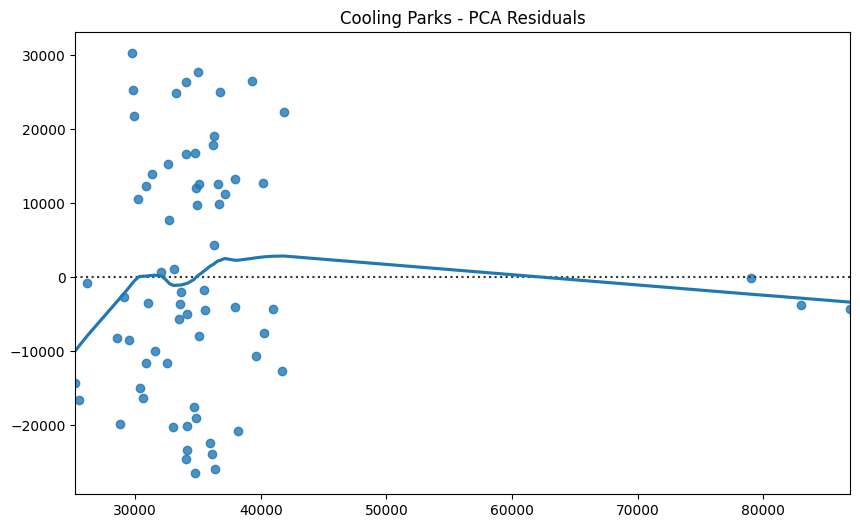


===== Cooling Parks - PCE Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2.439
Date:                Wed, 23 Jul 2025   Prob (F-statistic):             0.0560
Time:                        23:52:50   Log-Likelihood:                -231.54
No. Observations:                  68   AIC:                             473.1
Df Residuals:                      63   BIC:                             484.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

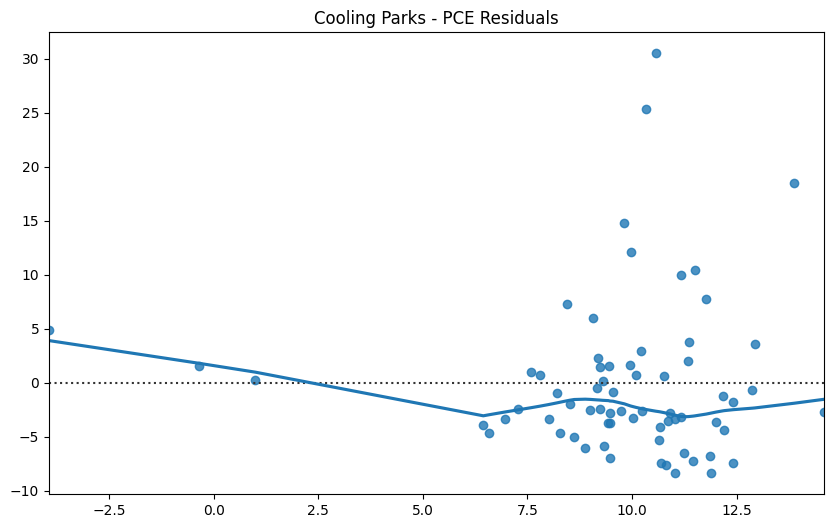


===== Heating Parks - PCI Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     28.62
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           1.29e-17
Time:                        23:52:50   Log-Likelihood:                -158.98
No. Observations:                 153   AIC:                             328.0
Df Residuals:                     148   BIC:                             343.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

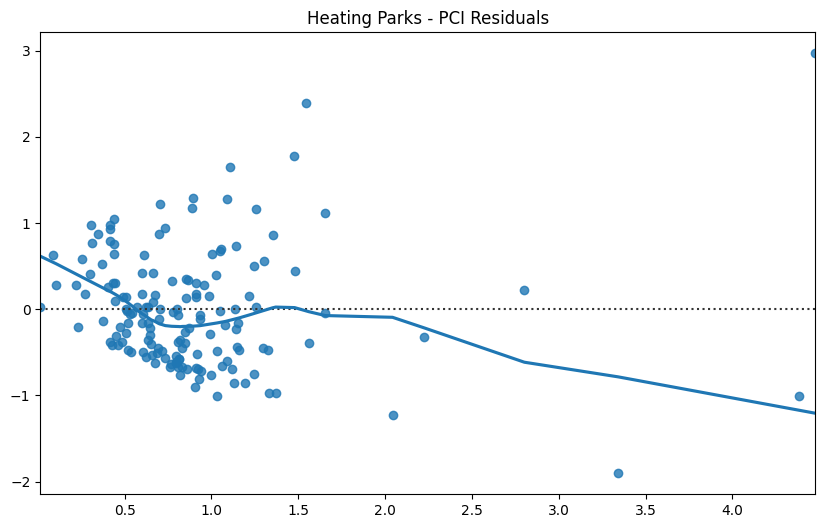


===== Heating Parks - PCA Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCA   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     21.18
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           7.96e-14
Time:                        23:52:51   Log-Likelihood:                -1690.1
No. Observations:                 153   AIC:                             3390.
Df Residuals:                     148   BIC:                             3405.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2

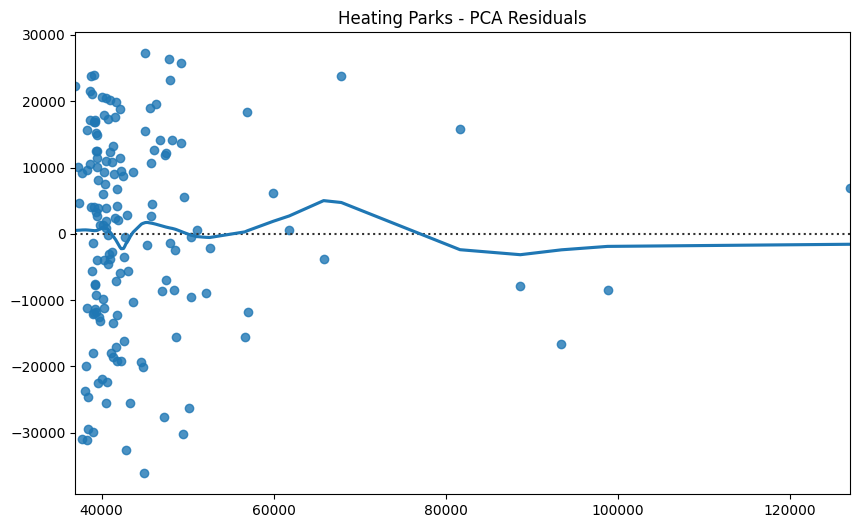


===== Heating Parks - PCE Model =====
                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     13.34
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           2.64e-09
Time:                        23:52:51   Log-Likelihood:                -502.24
No. Observations:                 153   AIC:                             1014.
Df Residuals:                     148   BIC:                             1030.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

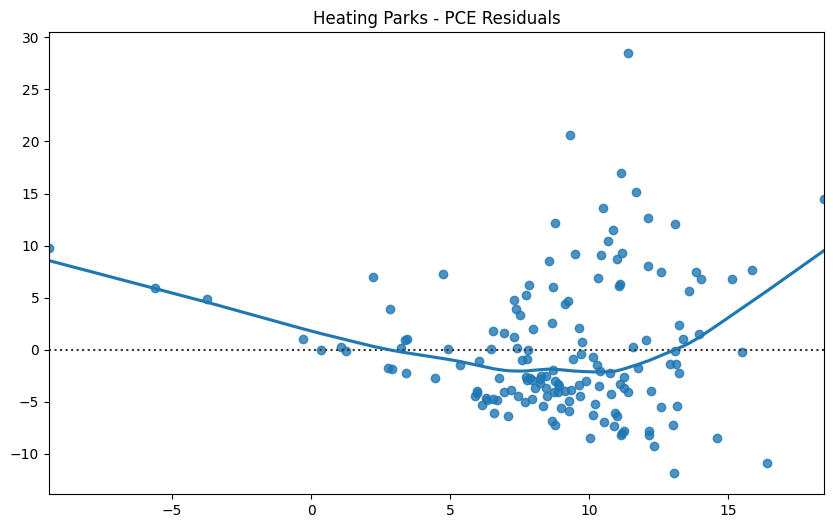

In [39]:
# Build separate regression models
def fit_group_model(df, group_name):
    """Fit full model for park group with diagnostics"""
    X = sm.add_constant(df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']])
    
    for target in ['PCI', 'PCA', 'PCE']:
        print(f"\n===== {group_name} Parks - {target} Model =====")
        model = OLS(df[target], X).fit()
        
        # Check model diagnostics
        if model.pvalues.max() > 0.05:
            print(f"Warning: Insignificant predictors in {target} model")
        
        print(model.summary())
        
        # Residual analysis
        plt.figure(figsize=(10,6))
        sns.residplot(x=model.predict(), y=model.resid, lowess=True)
        plt.title(f'{group_name} Parks - {target} Residuals')
        plt.show()
    
    return model

# Fit models for both groups
cooling_models = fit_group_model(data_df_cooling, "Cooling")
heating_models = fit_group_model(data_df_heating, "Heating")

In [41]:
def compare_coefficients():
    """Visual comparison of predictor effects across groups"""
    coef_data = []
    for target in ['PCI', 'PCA', 'PCE']:
        for predictor in ['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']:
            cooling_coef = getattr(cooling_models[target].params, predictor)
            heating_coef = getattr(heating_models[target].params, predictor)
            coef_data.append({
                'Target': target,
                'Predictor': predictor,
                'Cooling_Coeff': cooling_coef,
                'Heating_Coeff': heating_coef
            })
    
    coef_df = pd.DataFrame(coef_data)
    # Plot coefficient comparison
    g = sns.FacetGrid(coef_df, col='Target', height=4, aspect=1.2)
    g.map(sns.barplot, 'Predictor', 'Cooling_Coeff', color='blue', alpha=0.6)
    g.map(sns.barplot, 'Predictor', 'Heating_Coeff', color='red', alpha=0.6)
    g.set_axis_labels("Predictor", "Coefficient Value")
    g.add_legend(title='Park Type', labels=['Cooling', 'Heating'])
    plt.show()

compare_coefficients()
 

TypeError: 'RegressionResultsWrapper' object is not subscriptable

In [42]:
from statsmodels.formula.api import ols

# Test interaction effects
interaction_model = ols('PCI ~ ndvi_mean * I(PCI<0) + area_m2 * I(PCI<0)', data_df).fit()
print(interaction_model.summary())

# If interaction terms are significant (p<0.05), separation is justified

                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     68.78
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           1.04e-42
Time:                        23:55:44   Log-Likelihood:                -203.29
No. Observations:                 221   AIC:                             418.6
Df Residuals:                     215   BIC:                             439.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       